# Исследовательский проект по НИС «Анализ данных в Python»
<div style="text-align: right">
    Проект подготовлен студентами БПИ228
    <br>
    Лысиным Кириллом и Гакал Анжеликой
</div>

## Часть 2. Сбор данных из интернета и составление датасета.
Данную часть задания мы выполняли первой, так как её результаты являются предметом аналаза в следующей части задания.

После обсуждения вариантов мы решили собирать информацию о товарах и услугах, размещённых на сервисе объявлений Юла.
Выбором данного сервиса объявлений обусловлен ряд решений в области реализации:
<br>
<p style="margin-left: 50px;">
    <ul>
        <li>Библиотека requests, пройденная на занятиях, не позволяет получить все необходимые данные со страницы, так как часть контента отображается только после выполнения js-скриптов, что не происходит при использовании вышеуказанной библиотеки, поэтому для получения данных с сайта исопльзуется библиотека selenium.</li>
        <li>Работа с динамически генерируемым содержимым сайта делает невозможной (или крайне затруднительной) унификацию процесса, так как для разных устройств это содержимое может отличаться. Этим фактом обусловлена заточенность прогаммы, осуществляющей парсинг, под конкретное устройство, но изменения, необходимые для работы программы на другом устройстве могут быть внесены за незначительный промежуток времени.</li>
    </ul>
</p>

In [2]:
import datetime
from selenium import webdriver
import pandas as pd
import time
from bs4 import BeautifulSoup
import os.path


    
driver = webdriver.Chrome()

with open('visited_links.txt', 'w+') as f:
    visited_links = set(f.readlines())


def get_item_info(url):
    
    info_dict = {}
    soup = get_soup(url)
    if(soup == None):
        return
    
    general_info = str(soup.findAll('meta', {'property':"og:description"})[0])

    # Сохранение данных о товаре/услуге в словарь
    info_dict['Name'] = get_item_name(general_info)
    info_dict['Price (in rubles)'] = get_item_price(general_info)
    info_dict['Category'] = get_item_category(general_info)
    info_dict['Region'] = get_item_region(soup)
    info_dict['Time/date of placement'] = get_item_placement_time(soup)
    info_dict['Added to favourites'] = get_favourites(soup)
    info_dict['Number of seller\'s ads'] = get_number_of_ads(soup)
    info_dict['Seller rating'] = get_seller_rating(soup)
    info_dict['Number of views'] = get_number_of_views(soup)
    info_dict['Number of images'] = get_number_of_images(soup)
    info_dict['Link'] = url
    
    return info_dict

def get_soup(url, counter = 0):

    time.sleep(1)
    try:
        driver.get(url)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        return soup
    # Если не удалось сразу получить страницу, то программа пробует еще несколько раз
    except:
        if(counter < 3):
            return get_soup(url, counter + 1)
    # Если после несольких попыток так и не удалось считать содержимое страницы, то этот метод вернет None

def get_item_name(info):
    try:
        name = info[15:info.find('–') - 1]
        return name
    except:
        return None

def get_item_price(info):
    try:
        if not('Цена: ' in info):
            return 0
        price = float(info[info.find('Цена: ') + 6:info.find('руб.') - 1].replace(' ', ''))
        return price
    except:
        return 0

def get_item_category(info):
    try:
        category = info[info.find('раздела «') + 9:info.find('».')]
        return category
    except:
        return None

def get_item_region(soup):
    try:
        region = list(soup.findAll('span', class_='sc-cOxWqc hNYaaO'))[0].text
        return region
    except:
        return None

def get_item_placement_time(soup):
    try:
        s = list(soup.findAll('dd', class_='sc-cOxWqc sc-fVmuvm eOPaPs dVayGV'))[-1].text
        now = datetime.datetime.now()
        if('Сегодня в' in s):
            return datetime.datetime(now.year, now.month, now.day, int(s[-5:-3]), int(s[-2:]))
        if('Вчера в' in s):
            return (datetime.datetime(now.year, now.month, now.day, int(s[-5:-3]), int(s[-2:])) + datetime.timedelta(days=-1))
        if('Позавчера в' in s):
            return (datetime.datetime(now.year, now.month, now.day, int(s[-5:-3]), int(s[-2:])) + datetime.timedelta(days=-2))


        months = ['янв', 'фев', 'мар', 'апр', 'мая', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
        for j in range(len(months)):
            if(months[j].lower() in s):
                return datetime.datetime(now.year, j + 1, int(s[:2]), 12)
        return datetime.datetime(day=int(s[:2]), month=int(s[3:5]), year=int(s[6:10]), hour = 12)
    except:
        return None


def get_favourites(soup):
    try:
        favourites_count = list(soup.findAll('dd', class_="sc-cOxWqc sc-fVmuvm eOPaPs dVayGV"))
        return int(favourites_count[-3].text)
    except:
        return None

def get_number_of_ads(soup):
    try:
        n = list(soup.findAll('span', {'data-test-component':"UserNameClick"}))[0].text
        n = int(n[n.find('(')+1:n.find(' объявл')])
        return n
    except:
        return None

def get_seller_rating(soup):
    try:
        rating = soup.find('span', class_="sc-cOxWqc eDoIYl")
        return float(rating.text.replace(',', '.')) if rating != None else None
    except:
        return None

def get_number_of_views(soup):
    try:
        number_of_views = list(soup.findAll('dd', class_='sc-cOxWqc sc-fVmuvm eOPaPs dVayGV'))
        return int(number_of_views[-2].text)
    except:
        return None

def get_number_of_images(soup):
    try:
        images = list(soup.findAll('img', class_="sc-fBnnfK"))
        return len(images)
    except:
        return None

def get_links(scroll_count):
    
    url = r'https://youla.ru/'
    driver.get(url)
    time.sleep(1)
    
    for i in range(scroll_count):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    links = [str(i.a) for i in soup.findAll('span', class_="sc-llGDqb sc-gqgnwQ fEAASo hZGRky")]
    links = [r'https://youla.ru' + s[s.find(r'href="') + 6 : s.find(r'" rel')] for s in links]
    return links



n = 50
for i in range(n):
    items = []
    print(f"Processing batch {i + 1} out of {n}:", end='')
    links = get_links(1)
    for i in range(len(links)):
        if(int(i * 100/len(links))//5 > int((i - 1) * 100/len(links))//5):
            print(' .', end='')
        link = links[i]
        if(link in visited_links):
            continue
        items.append(get_item_info(link))
        visited_links.add(link)
    print(' ✓')

    df = pd.DataFrame(items)
    if(len(df) > 0):
        df = df.set_index('Name')
        if(os.path.isfile('items.xlsx')):
            prev_df = pd.read_excel('items.xlsx', index_col = 0)
            df = pd.concat([prev_df, df])

        df.to_excel('items.xlsx')

print("Done! The data has been saved to the file items.xlsx")

with open('visited_links.txt', 'a') as f:
    for line in visited_links:
        f.write(f"{line}\n")



driver.quit()
df

Processing batch 1 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 2 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 3 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 4 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 5 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 6 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 7 out of 50: . . . . . . . . . . . . ✓
Processing batch 8 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 9 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 10 out of 50: . . . . . . . . . . . . ✓
Processing batch 11 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 12 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 13 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 14 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 15

,Price (in rubles),Category,Region,Time/date of placement,Added to favourites,Number of seller's ads,Seller rating,Number of views,Number of images,Link
Name,,,,,,,,,,
Брюки 80-92,0.0,Детский гардероб,Москва,2023-01-31 22:00:00,2.0,40.0,5.0,14.0,5,https://youla.ru/moskva/detskaya-odezhda/shtan...
Туфли размер 30. Бесплатно,0.0,Детский гардероб,Химки,2023-01-31 21:59:00,0.0,54.0,5.0,18.0,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...
Кошка бесплатно,0.0,Животные,Москва,2023-01-31 21:59:00,7.0,1.0,NaN,307.0,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...
Demix на 6 лет на синтепоне,0.0,Детский гардероб,Котельники,2023-01-31 21:59:00,0.0,111.0,5.0,127.0,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...
Красивый пёс в добрые руки,0.0,Животные,Люберцы,2023-01-31 21:59:00,151.0,19.0,NaN,8402.0,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...
...,...,...,...,...,...,...,...,...,...,...
Очки без диоптрий,300.0,Красота и здоровье,Москва,2023-02-03 17:17:00,0.0,3.0,5.0,0.0,4,https://youla.ru/moskva/krasota-i-zdorove/medi...
Новое платье паетки,1800.0,Женский гардероб,Москва,2023-02-03 11:01:00,0.0,173.0,5.0,1.0,5,https://youla.ru/moskva/zhenskaya-odezhda/plat...
Люстра 80-е годы,3000.0,Для дома и дачи,Москва,2023-01-27 12:00:00,0.0,6.0,5.0,15.0,3,https://youla.ru/moskva/dom-dacha/osveshchenie...


## Часть 1. Анализ датасета.

Загружаем содержимое файла items.xlsx, в котором содержатся данные, полученные в ходе выполнения части 2 проекта.  
Переименуем некоторые столбцы для удобства и выведем первые 5 строк датафрейма.

In [273]:
import pandas as pd

df = pd.read_excel("items.xlsx")
# Переименуем названия столбцов датасета для более удобного доступа к ним
df = df.rename(
    columns={
        'Time/date of placement': 'Placement_time',
        'Added to favourites': 'Favourites_count',
        'Number of views':'Views',
        'Number of images':'Images',
        'Price (in rubles)':'Price',
        'Number of seller\'s ads':'Ads_count',
        'Seller rating':'Seller_rating'
    })
df.head()


,Name,Price,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link
0,Брюки 80-92,0.000,Детский гардероб,Москва,2023-01-31 22:00:00,2.000,40.000,5.000,14.000,5,https://youla.ru/moskva/detskaya-odezhda/shtan...
1,Туфли размер 30. Бесплатно,0.000,Детский гардероб,Химки,2023-01-31 21:59:00,0.000,54.000,5.000,18.000,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...
2,Кошка бесплатно,0.000,Животные,Москва,2023-01-31 21:59:00,7.000,1.000,NaN,307.000,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...
3,Demix на 6 лет на синтепоне,0.000,Детский гардероб,Котельники,2023-01-31 21:59:00,0.000,111.000,5.000,127.000,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...
4,Красивый пёс в добрые руки,0.000,Животные,Люберцы,2023-01-31 21:59:00,151.000,19.000,NaN,8402.000,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...


### Описание датасета

<i><b>- Определим размер датасета:</b></i>

In [274]:
size = df.shape
print(f"Количество строк (наблюдений): {size[0]}\n"+
     f'Количество столбцов (переменных): {size[1]}')

Количество строк (наблюдений): 10922
Количество столбцов (переменных): 11


<b><i>- Опишем переменные:</b></i>

In [275]:
columns = df.columns.to_list()
column_types = [str(i).ljust(15, ' ') for i in df.dtypes.to_list()]
na_count = [str(i) for i in df.isna().sum()]

s = [str(i) for i in df['Category']]
df['Category'] = s;
print("В датасете содержатся следующие переменные:")
print(*[('\t' + i).ljust(20, ' ') + "|тип данных переменной: " + j + "|число пустых значений: " + k for i, j, k in zip(columns, column_types, na_count)], sep='\n')

В датасете содержатся следующие переменные:
	Name               |тип данных переменной: object         |число пустых значений: 0
	Price              |тип данных переменной: float64        |число пустых значений: 0
	Category           |тип данных переменной: object         |число пустых значений: 0
	Region             |тип данных переменной: object         |число пустых значений: 28
	Placement_time     |тип данных переменной: datetime64[ns] |число пустых значений: 303
	Favourites_count   |тип данных переменной: float64        |число пустых значений: 301
	Ads_count          |тип данных переменной: float64        |число пустых значений: 369
	Seller_rating      |тип данных переменной: float64        |число пустых значений: 4909
	Views              |тип данных переменной: float64        |число пустых значений: 28
	Images             |тип данных переменной: int64          |число пустых значений: 0
	Link               |тип данных переменной: object         |число пустых значений: 0


<p style="margin-left:5em;">
    <ul>
        <li><em>Name</em> - наименование товара/услуги. Категориальная переменная</li>  
        <li><em>Price</em> - цена товара/услуги в рублях. Метрическая переменная</li>  
        <li><em>Category</em> - категория товара. Категориальная переменная (Номинальная)</li>
        <li><em>Region</em> - местоположение продавца. Категориальная переменная (Номинальная)</li>
        <li><em>Placement_time</em> - дата и время размещения объявления. Метрическая переменная</li> 
        <li><em>Favourites_count</em> - количество людей, добавивших объявление в избранное. Метрическая переменная</li>
        <li><em>Ads_count</em> - количество объявлений, которые разместил продваец на сервисе. Метрическая переменная</li>
        <li><em>Seller_rating</em> - рейтинг продавца по пятибалльной шкале. Категориальная переменная (Порядковая)</li>
        <li><em>Views</em> - количество просмотров объявления. Метрическая переменная</li>
        <li><em>Images</em> - количество фотографий, прикреплённых к объявлению. Метрическая переменная</li>
        <li><em>Link</em> - ссылка на объявление</li>
    </ul>
</p>

<b><i>- Изменение типов данных:</i></b>
<br>Для данного датасета не нужно изменять типы данных в столбцах, так как он был составлен с учётом необходимости дальнейшего анализа.

### Добавление новых столбцов

Добавим новые колонки:
<ul>
    <li><em>Favourites_percent</em>, отражающую процент тех пользователей, которые добавили товар в избранное из числа людей, просмотревших объявление. (Категориальная (порядковая) переменная, тип значений в столбце - float64)</li>
    <li><em>Free_item</em>, показывающую, является ли товар/услуга бесплатной. (Категориальная (бинарная) переменная, тип значений в столбце - bool)</li>
    <li><em>Weekday</em>, показывающую день недели, в который разместили товар. (Категориальная (порядковая) переменная, тип значений в столбце - string)</li>
</ul>

In [276]:
favourites_percent = [i/j * 100 if j != 0 else None for i, j in zip(df["Favourites_count"], df["Views"])]
free = [i == 0 for i in df["Price"]]
df['Favourites_percent'] = favourites_percent
df['Free_item'] = free
df["Weekday"] = df["Placement_time"].apply(lambda x : ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"][x.weekday()] if pd.notnull(x) else x)
df.head()


tempDf = df.copy(deep = True)
tempDf = tempDf.dropna(subset=["Favourites_percent"])
tempDf.sort_values(["Favourites_percent"]).tail(50)

,Name,Price,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link,Favourites_percent,Free_item,Weekday
6052,Мясорубка Moulinex ME108832,3500.000,Бытовая техника,Москва,2023-02-03 00:28:00,1.000,17.000,NaN,2.000,10,https://youla.ru/moskva/bytovaya-tekhnika/izme...,50.000,False,Пятница
348,Зарядная станция ps5 dualsense ps4,2700.000,Компьютерная техника,Москва,2023-01-31 19:29:00,1.000,14.000,5.000,2.000,4,https://youla.ru/moskva/kompyutery/ruli-dzhois...,50.000,False,Вторник
5108,Кроватка детская GRACO,3000.000,Детские товары,Москва,2023-02-02 20:39:00,1.000,55.000,5.000,2.000,4,https://youla.ru/moskva/detskie/drugoe/krovatk...,50.000,False,Четверг
4941,Кровать 140х200,27390.000,Для дома и дачи,Москва,2023-02-01 16:48:00,1.000,1563.000,NaN,2.000,10,https://youla.ru/moskva/dom-dacha/krovati/krov...,50.000,False,Среда
2493,Электро плита стекло керамика,15000.000,Бытовая техника,Москва,2023-02-01 19:58:00,1.000,1.000,NaN,2.000,3,https://youla.ru/moskva/bytovaya-tekhnika/plit...,50.000,False,Среда
6471,USB колонки Perfeo PF-053 Rondo для компьютера (6,550.000,Компьютерная техника,Москва,2023-01-28 12:00:00,1.000,7.000,5.000,2.000,2,https://youla.ru/moskva/kompyutery/multimedia/...,50.000,False,Суббота
1657,"Стрижки,окрашивание,укладка",150.000,Красота и здоровье,Москва,2023-01-31 23:23:00,1.000,1.000,NaN,2.000,10,https://youla.ru/moskva/krasota-i-zdorove/uhod...,50.000,False,Вторник
3131,"Фигуры для сада, парка, дома.",2000.000,Для дома и дачи,Москва,2023-02-01 16:19:00,1.000,4.000,5.000,2.000,5,https://youla.ru/moskva/dom-dacha/oformlenie-i...,50.000,False,Среда
5704,Передежка собакк,400.000,Животные,Москва,2023-02-03 00:31:00,1.000,2.000,NaN,2.000,2,https://youla.ru/moskva/zhivotnye/sobaki/pieri...,50.000,False,Пятница
6779,Матрас 160х200 ортопедический,10620.000,Для дома и дачи,"Москва, Зеленодольская улица, 33к1",2023-02-02 12:19:00,1.000,1532.000,5.000,2.000,3,https://youla.ru/moskva/dom-dacha/krovati/matr...,50.000,False,Четверг


<b><em>- Перекодирование переменных</em></b>
<br>
Добавим столбец <em>Price_range</em>, в котором перекодируем метрическую переменную <em>Price</em> в категориальную.
Все цены разделели на 5 категорий:
<ul>
    <li><em>free</em> - бесплатные товары</li>
    <li><em>small price</em> - недорогие товары (стоимостью до 5000 рублей)</li>
    <li><em>affordable</em> - товары среднего ценового сегмента (от 5000 до 15000 рублей)</li>
    <li><em>expensive</em> - дорогие товары (от 15000 до 100000 рублей)</li>
    <li><em>luxury</em> - товары роскоши (стоимостью более 100000 рублей)</li>
</ul>

In [277]:
price_range = ["free" if x == 0 else "small price" if x <= 5000 else "affordable" if x <= 15000 else "expensive" if x <= 100000 else "luxury" for x in df['Price']]
df.insert(2, 'Price_range', price_range)

In [278]:
df.head(10)

,Name,Price,Price_range,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link,Favourites_percent,Free_item,Weekday
0,Брюки 80-92,0.000,free,Детский гардероб,Москва,2023-01-31 22:00:00,2.000,40.000,5.000,14.000,5,https://youla.ru/moskva/detskaya-odezhda/shtan...,14.286,True,Вторник
1,Туфли размер 30. Бесплатно,0.000,free,Детский гардероб,Химки,2023-01-31 21:59:00,0.000,54.000,5.000,18.000,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...,0.000,True,Вторник
2,Кошка бесплатно,0.000,free,Животные,Москва,2023-01-31 21:59:00,7.000,1.000,NaN,307.000,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...,2.280,True,Вторник
3,Demix на 6 лет на синтепоне,0.000,free,Детский гардероб,Котельники,2023-01-31 21:59:00,0.000,111.000,5.000,127.000,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...,0.000,True,Вторник
4,Красивый пёс в добрые руки,0.000,free,Животные,Люберцы,2023-01-31 21:59:00,151.000,19.000,NaN,8402.000,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...,1.797,True,Вторник
5,!Зимний конверт на выписку.,0.000,free,Детский гардероб,Апрелевка,2023-01-31 21:59:00,7.000,4.000,5.000,499.000,3,https://youla.ru/aprelevka/detskaya-odezhda/ko...,1.403,True,Вторник
6,Диски для гантелей,150.000,small price,Спорт и отдых,Москва,2023-01-31 14:51:00,0.000,607.000,5.000,3.000,3,https://youla.ru/moskva/sport-otdyh/trenazhery...,0.000,False,Вторник
7,6 16 коробка,100000.000,expensive,Легковые автомобили,Москва,2023-01-31 17:22:00,1.000,1.000,NaN,13.000,6,https://youla.ru/moskva/auto/s-probegom/6-16-k...,7.692,False,Вторник
8,"Подушки Бамбук новые, в упаковках",450.000,small price,Для дома и дачи,Москва,2023-01-31 12:58:00,160.000,9.000,NaN,3060.000,0,https://youla.ru/moskva/dom-dacha/tekstil-kovr...,5.229,False,Вторник
9,Щенки той пуделя Ркф -FCI,0.000,free,Животные,Москва,2023-01-28 12:00:00,11.000,1.000,NaN,476.000,5,https://youla.ru/moskva/zhivotnye/sobaki/shchi...,2.311,True,Суббота


<b><em>- Формирование среза таблицы и его транспонирование</em></b>

Выберем случайные 15 подряд идущих строк из датафрейма и транспонируем их.

In [279]:
import random as rand
k = rand.randint(0, size[0] - 15)
df.loc[k:k+15, :].T

,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525
Name,Юбка,Чемодан SUPRA,Женское платье эко кожа р.48,Айфон 5 s,Мису ц,Xbox one 1TB + 2 геймпад,РАСПРОДАЖА Электрощит ЩРв-12з-1 36,Зеркало Ford Focus 3 (2015-2019) УНИВЕРСАЛ 1 2016,Комод №6,"Детский костюм Columbia.Куртка,штаны.",Филодендрон кобра,Комбинезон-трансформер,"Hyundai ix55, 2011",Попугай жако,ACER AMD A10 4600/6gb/500gb/2gb radeon 7660,Шлем зимний Etape Race White Mat (Размер шлема...
Price,500.000,3000.000,1150.000,4000.000,1100.000,25000.000,200.000,4500.000,4830.000,3500.000,350.000,2000.000,1243000.000,130000.000,14950.000,5490.000
Price_range,small price,small price,small price,small price,small price,expensive,small price,small price,small price,small price,small price,small price,luxury,luxury,affordable,affordable
Category,Женский гардероб,Спорт и отдых,Женский гардероб,Хобби и развлечения,Детские товары,Хобби и развлечения,Стройматериалы и инструменты,Запчасти и автотовары,Для дома и дачи,Детский гардероб,Для дома и дачи,Детский гардероб,Легковые автомобили,Животные,Компьютерная техника,Спорт и отдых
Region,Москва,Москва,Москва,Москва,Москва,Москва,Москва,"Россия, Москва, Дорожная улица, 60Ас1",Москва,Москва,Москва,Москва,Москва,Москва,Москва,Москва
Placement_time,2023-01-29 11:07:00,2023-01-26 12:00:00,2023-01-31 01:32:00,2023-01-30 11:12:00,2023-01-19 12:00:00,2023-01-14 12:00:00,2023-01-13 12:00:00,2023-01-26 12:00:00,2023-01-30 16:22:00,2023-01-28 12:00:00,2023-01-31 16:23:00,2023-01-29 19:07:00,2023-01-31 22:23:00,2023-01-31 22:02:00,2023-01-06 12:00:00,2023-01-31 11:04:00
Favourites_count,4.000,5.000,1.000,0.000,0.000,10.000,20.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,12.000,0.000
Ads_count,33.000,4.000,332.000,1.000,1.000,4.000,12.000,1811.000,3568.000,15.000,50.000,15.000,215.000,25.000,6486.000,1344.000
Seller_rating,5.000,4.900,4.700,NaN,NaN,NaN,5.000,NaN,5.000,5.000,NaN,5.000,NaN,5.000,5.000,NaN
Views,169.000,41.000,24.000,6.000,10.000,772.000,409.000,32.000,0.000,354.000,0.000,9.000,1.000,3.000,336.000,0.000


<b><em> - Многоуровневая сортировка</em></b>

Отсортируем датафрейм сначала по убыванию цены, а затем по убыванию количества просмотров. После этого выведем первые 20 наблюдений из отсортированного датасета.

In [280]:
sortedDf = df.dropna(subset = ['Price', 'Views']).sort_values(['Price', 'Views'], ascending=[False, False])
sortedDf.iloc[:20, :][['Price', 'Views']]

,Price,Views
7405,74900000.000,65.000
6648,40000000.000,2228.000
2319,40000000.000,2211.000
570,40000000.000,2184.000
9315,15000000.000,6041.000
5733,15000000.000,6038.000
5256,15000000.000,6036.000
7370,12000000.000,652.000
3545,12000000.000,648.000
2893,12000000.000,632.000


### Цель и задачи исследования

<b>Цель исследования:</b> проанализировать факторы, влияющие на заинтересованность покупателей в товарах разных категорий, а также выявить оптимальные стратегии для продавцов при реализации товаров.
<br><br>
<b>Задачи исследования:</b>
<ol>
    <li>Сформировать исследовательские гипотезы</li>
    <li>Построить графики, отражающие зависимость между выбранными переменными датасета</li>
    <li>Проанализировать данные, полученные на предыдущих этапах исследования</li>
    <li>Подтвердить или опровергнуть поставленные гипотезы</li>
</ol>

### Формирование исследовательских гипотез

<b>H1. </b>Рейтинг продавца зависит от количества размещённых объявлений<br>
<b>H2. </b>Объявления категории "Телефоны и планшеты" представлены наиболее широко - данная категория товаров является высоко конкурентной<br>
<b>H3. </b>Товары, относящиеся к предметам роскоши, составляют наибольший процент от всех товаров в Москве<br>


<b>H4. </b>Отношение услуг к товарам меньше 20%<br>
<b>H5. </b>Количество людей, добавивших товар в избранное, увеличивается с уменьшением цены.<br>
<b>H6. </b>Чем больше фотографий представлено в объявлении, тем больше процент людей, добавивших товар в избранное, из числа просмотревших<br>
<b>H7. </b>Покупатели больше обращают внимания на товары из среднего ценового сегмента<br>
<b>H8. </b>Средняя цена на товары из категорий "Недвижимость", "Легковые автомобили", "Бытовыая техника", "Одежда" в Москве выше средней цены в других регионах<br> 
<b>H9. </b>На выходных активность продавцов на сайте выше<br>
<b>H10. </b>Заинтересованность покупателей в бесплатных товарах в выбранных категориях выше, чем в платных.<br>

Перед проверкой гипотез рассчитаем описательные статистики, характеризующие центральную тенденцию и
разброс значений относительно меры центральной тенденции. Полученные данные будут полезны при дальнейшей проверке гипотез.

In [281]:
df.describe()

,Price,Favourites_count,Ads_count,Seller_rating,Views,Images,Favourites_percent
count,10922.000,10621.000,10553.000,6013.000,10894.000,10922.000,9878.000
mean,176019.776,7.211,237.429,4.961,278.390,5.101,3.956
std,1145784.724,31.354,1056.622,0.216,1412.285,3.942,7.305
min,0.000,0.000,1.000,1.000,0.000,0.000,0.000
25%,800.000,0.000,2.000,5.000,6.000,2.000,0.000
50%,4000.000,1.000,15.000,5.000,36.000,4.000,2.181
75%,23000.000,5.000,158.000,5.000,136.000,8.000,5.263
max,74900000.000,1346.000,17664.000,10.000,51781.000,14.000,100.000


По данной таблице можно установить следующие тенденции и взаимосвязи:
<ul>
    <li>Средняя цена товаров выборки - 176000 рублей</li>
    <li>Столбец с рейтингом продавца содержит много пропущенных значений (порядка 40-50% от всех наблюдений)</li>
    <li>Половина всех товаров дешевле 4000 рублей</li>
    <li>Стандартное отклонение по количеству объявлений продавца велико</li>
    <li>Максимальное количество просмотров объявления - 51781</li>
    <li>Только 25% объявлений содержат не менее 8 изображений</li>
</ul>

Определим моду по категориальным переменным датасета:

In [282]:
for category in ["Price_range", "Category", "Region", "Free_item", "Weekday"]:
    print(f'Мода по \"{category}\": {df[category].mode().iat[0]}')

Мода по "Price_range": small price
Мода по "Category": Легковые автомобили
Мода по "Region": Москва
Мода по "Free_item": False
Мода по "Weekday": Четверг


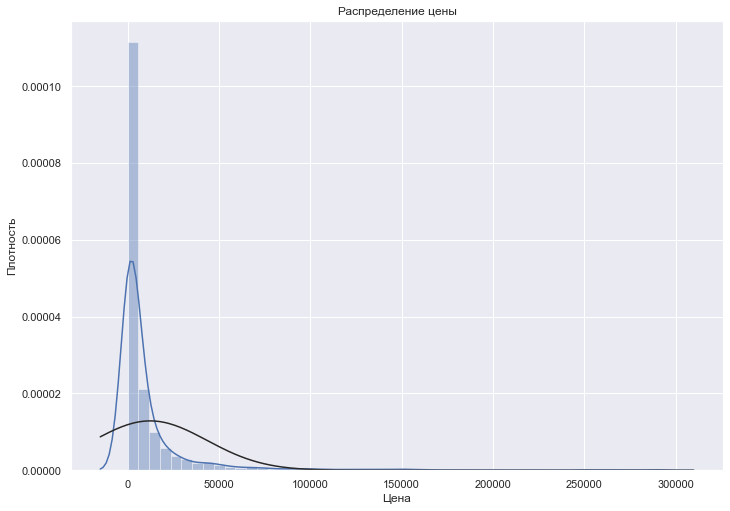

In [283]:
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

sns.distplot(df[df["Price"] < 300000].Price.dropna(), fit=norm)
plt.title("Распределение цены")
plt.xlabel("Цена")
plt.ylabel("Плотность")
plt.show()

In [284]:
print(f'Ассиметрия: {df[df["Price"] < 300000].Price.skew():.3f}')

Ассиметрия: 5.287


In [285]:
print(f'Эксцесс: {df[df["Price"] < 300000].Price.kurtosis()}')

Эксцесс: 34.057609889320325


Распределение цены по датасету не соответсвует нормальному.  

Рассмотрим распределение цены по конкретной категории - "Телефоны и планшеты"

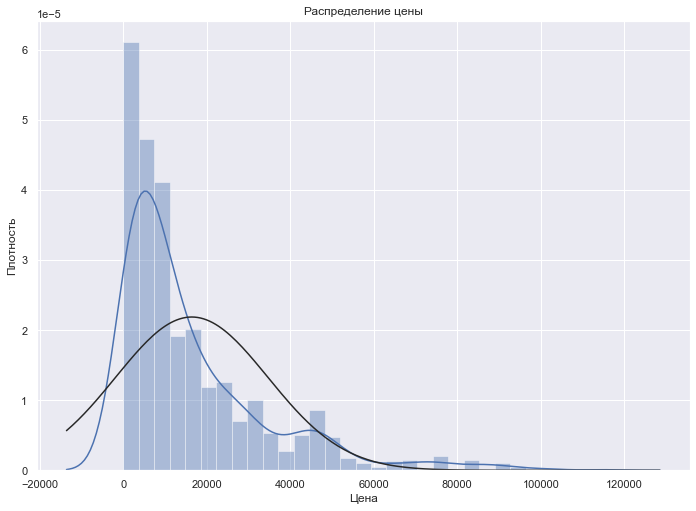

In [286]:
sns.distplot(df[(df["Price"] < 300000) & (df["Category"] == "Телефоны и планшеты") & (~df["Free_item"])].Price.dropna(), fit=norm)
plt.title("Распределение цены")
plt.xlabel("Цена")
plt.ylabel("Плотность")
plt.show()

Полученное распределние отличается от общего распределения, что говорит о том, что внутри категорий может быть другим, чего и следовало ожидать.

### Проверка гипотез

<h4><b>H1. </b>Рейтинг продавца зависит от количества размещённых объявлений</h4>
Для проверки данной гипотезы посчитаем корреляцию между пересенными и построим heatmap с помощью библиотеки seaborn.


Сначала исключим те строки, данные о рейтинге в которых пропущены.

In [287]:
ratingDf = df.dropna(subset = ['Seller_rating'])

Посчитаем значение корреляции между рейтингом продавца и количеством объявлений.

0.01868


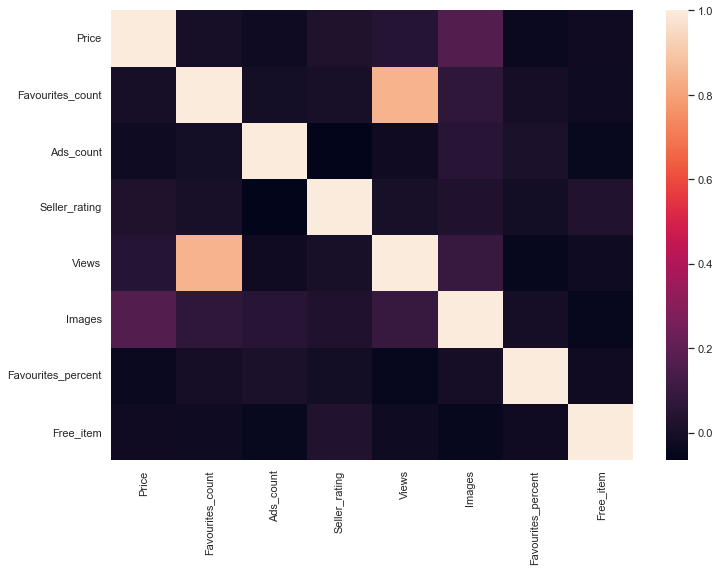

In [288]:
import seaborn as sns
sns.heatmap(ratingDf.corr())
print(f"{ratingDf['Seller_rating'].corr(ratingDf['Price']):.5f}")

Корреляция между рейтингом и количеством объявлений продавца отсутствует - <i><u>гипотеза не подтвердилась.</u></i>  
Построенная диаграмма показывает, что в данном датасете сильная корреляция наблюдается только между количеством людей, добавивших товар в избранное, и количеством просмотров объявления. Также присутствует слабая корреляция между ценой товара и числом изображений, прикреплённых к объявлению. Корреляция между другими столбцами отсутсвует, это может быть связано с тем фактом, что датасет содержит данные о товарах из множества разных категорий и те корреляции, которые могли бы присутствовать при рассмотрении конкретной категории, не проявляются

<h4><b>H2. </b>Объявления категории "Телефоны и планшеты" представлены наиболее широко - данная категория товаров является высоко конкурентной</h4>
Для проверки данной гипотезы посторим столбчатую диаграмму, отражающую количество объявлений в каждой категории

Посчитаем количество товаров и услуг в каждой категории.

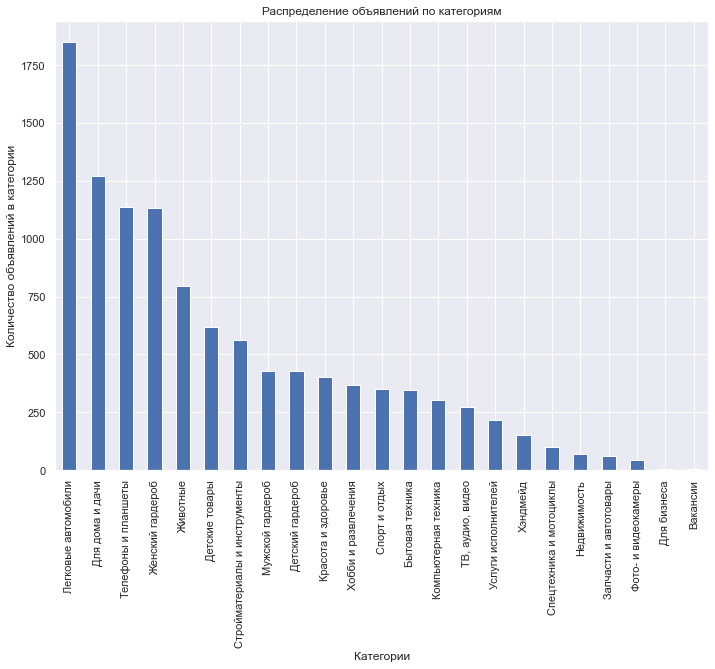

Category
Легковые автомобили             1849
Для дома и дачи                 1269
Телефоны и планшеты             1138
Женский гардероб                1134
Животные                         796
Детские товары                   618
Стройматериалы и инструменты     564
Мужской гардероб                 430
Детский гардероб                 429
Красота и здоровье               404
Хобби и развлечения              367
Спорт и отдых                    352
Бытовая техника                  346
Компьютерная техника             303
ТВ, аудио, видео                 272
Услуги исполнителей              216
Хэндмейд                         152
Спецтехника и мотоциклы           99
Недвижимость                      70
Запчасти и автотовары             60
Фото- и видеокамеры               44
Для бизнеса                        6
Вакансии                           4
dtype: int64

In [289]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
category_counts = df.value_counts("Category")
ax = category_counts.plot(kind="bar")
ax.set_xlabel("Категории")
ax.set_ylabel("Количество объявлений в категории")
plt.title("Распределение объявлений по категориям")
plt.show()
category_counts

<i>Гипотеза не подтвердилась.</i><br>
Категория "Телефоны и планшеты" находится лишь на третьем месте по количеству объявлений (1138 объявлений), её превосходят категории "Для дома и дачи" (1269 объявлений) и "Легковые автомобили" (1849 объявлений). Все 3 упомянутых категории товаров высоко конкуретны, это значит, что большие перспективы откроются продавцам в других категориях, но также это может означать, что данные категории пользуются большим спросом, а значит они могут подходить продавцам, готовым к реализации своего товара на высоко конкурентном рынке.


<h4><b>H3. </b>Товары, относящиеся к предметам роскоши, составляют наибольший процент от всех товаров в Москве по сравнению с другими регионами</h4>
Для проверки данной гипотезы будем анализировать переменные "Region" и "Price_range". Выбранный метод анализа: построение столбчатой диаграммы

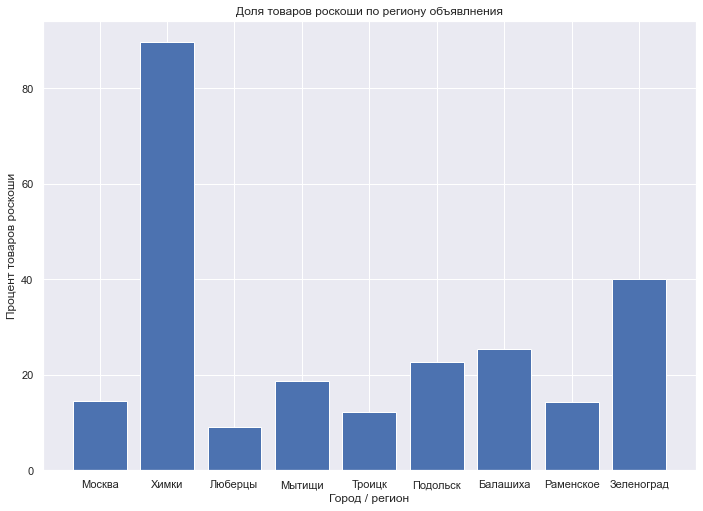

In [290]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.options.mode.chained_assignment = None
dfRegion = df.dropna(subset=["Region"])
dfRegion["Region"] = dfRegion["Region"].map(lambda x: "Москва" if ("Москва" in x) else x)

# Будем рассматривать регионы, в которых есть хотя бы 20 объявлений
multipleOccurences = []
luxuryPercent = []
regions = []

for i in dfRegion["Region"].unique():
    
    if(dfRegion.Region.value_counts()[i] > 20):
        regions.append(i)
        luxuryCount = dfRegion[(dfRegion["Price_range"] == "luxury") & (dfRegion["Region"] == i)].shape[0]
        totalCount = dfRegion[(dfRegion["Region"] == i)].shape[0]
        luxuryPercent.append(luxuryCount / totalCount * 100)

plt.bar(regions, luxuryPercent)
plt.title("Доля товаров роскоши по региону объявлнения")
plt.xlabel("Город / регион")
plt.ylabel("Процент товаров роскоши")
plt.show()

<i>Гипотеза не подтвердилась</i> - по графику видно, что товары роскоши в Москве составляют около 15% всех товаров, в то время как в некоторых других регионах эта цифра может достигать 30-40%, а в Химках около 95%, что является интересной аномалией.<br><i>Исследуем причины её возникновения.</i>  
Для этого построим круговую диаграмму и выведем датафрейм, в котором содержатся лишь записи по городу Химки

In [291]:
dfRegion[dfRegion["Region"] == "Химки"].head(15)

,Name,Price,Price_range,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link,Favourites_percent,Free_item,Weekday
1,Туфли размер 30. Бесплатно,0.000,free,Детский гардероб,Химки,2023-01-31 21:59:00,0.000,54.000,5.000,18.000,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...,0.000,True,Вторник
88,"ВАЗ (Lada) Largus, 2018",545000.000,luxury,Легковые автомобили,Химки,2023-01-30 12:22:00,0.000,311.000,NaN,6.000,14,https://youla.ru/himki/auto/s-probegom/vaz-lad...,0.000,False,Понедельник
193,"Hyundai Creta, 2021",1219000.000,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,0.000,312.000,NaN,22.000,9,https://youla.ru/himki/auto/s-probegom/hyundai...,0.000,False,Среда
255,"Kia Sorento, 2014",980000.000,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,4.000,308.000,NaN,66.000,14,https://youla.ru/himki/auto/s-probegom/kia-sor...,6.061,False,Среда
316,"Geely Atlas, 2018",990000.000,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,0.000,292.000,NaN,96.000,14,https://youla.ru/himki/auto/s-probegom/geely-a...,0.000,False,Среда
317,"Land Rover Discovery, 2011",1040000.000,luxury,Легковые автомобили,Химки,2023-01-19 12:00:00,0.000,313.000,NaN,86.000,9,https://youla.ru/himki/auto/s-probegom/land-ro...,0.000,False,Четверг
319,"Land Rover Freelander, 2011",890000.000,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,1.000,315.000,NaN,35.000,14,https://youla.ru/himki/auto/s-probegom/land-ro...,2.857,False,Среда
320,"Geely Atlas, 2018",1140000.000,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,0.000,292.000,NaN,13.000,14,https://youla.ru/himki/auto/s-probegom/geely-a...,0.000,False,Среда
327,"Kia Optima, 2017",700000.000,luxury,Легковые автомобили,Химки,2023-01-25 12:00:00,19.000,308.000,NaN,495.000,14,https://youla.ru/himki/auto/s-probegom/kia-opt...,3.838,False,Среда
365,"Kia Cee'd, 2016",755000.000,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,1.000,311.000,NaN,33.000,14,https://youla.ru/himki/auto/s-probegom/kia-cee...,3.030,False,Среда


Можно заметить, что в представленном датафрейме по городу Химки содержится много записей о товарах категории "Легковые автомобили":

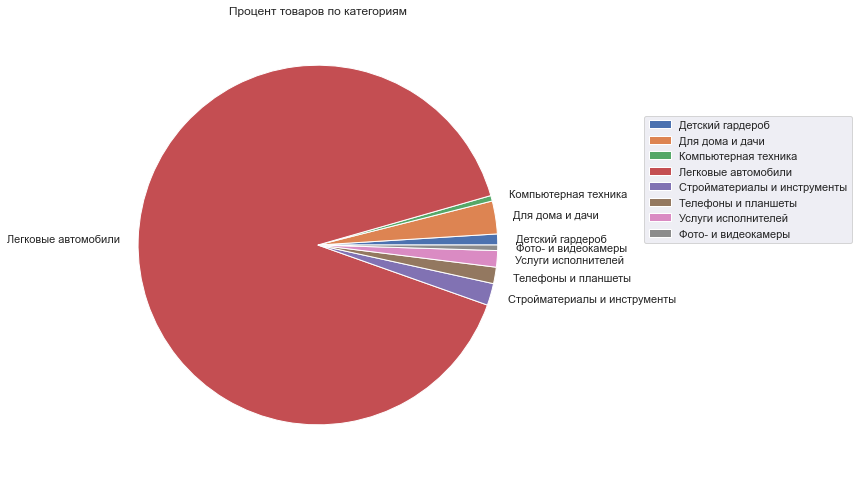

In [297]:
dfRegion[dfRegion["Region"] == "Химки"].groupby('Category').size().plot(kind='pie', title = "Процент товаров по категориям", ylabel = "")
plt.legend(dfRegion[dfRegion["Region"] == "Химки"].groupby('Category').size().index, loc="upper right", bbox_to_anchor=(1.7, 0.8))
plt.show()

Построенная диаграмма делает очевидным тот факт, что в городе Химки есть крупный продавец легковых автомобилей, поэтому значительная часть товаров в этом городе относится к категории роскоши.

<h4><b>H4. </b>Отношение количества услуг к товарам меньше 20%</h4>
Для проверки данной гипотезы будем анализировать столбец "Category". Выбранный метод анализа: Построение круговой диаграммы

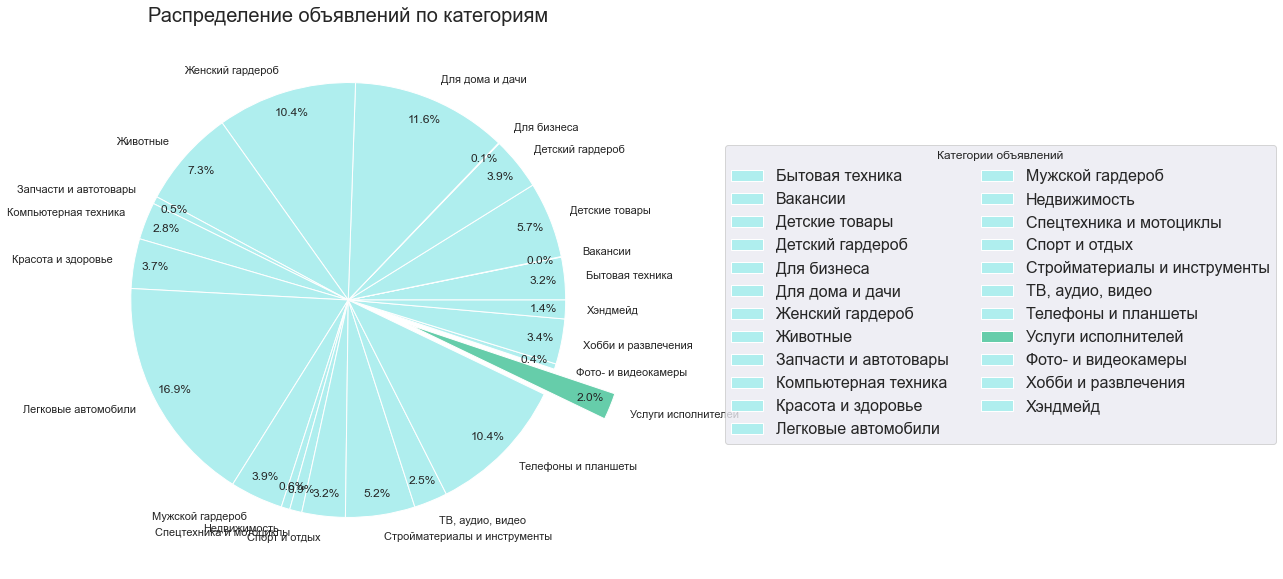

Отношение услуг к товарам составляет 2.018%


In [243]:
import matplotlib.pyplot as plt
categoriesSeries = df.groupby('Category').size()
plt.figure(figsize=(10, 10))

plt.pie(
    categoriesSeries,
    explode = [0.3 if i == 19 else 0 for i in range(23)],
    labels = categoriesSeries.index, 
    colors = ['mediumaquamarine' if i == 19 else 'paleturquoise' for i in range(23)],
    autopct='%.1f%%',
    pctdistance=0.9
    )
plt.title("Распределение объявлений по категориям", fontdict = {'fontsize' : 20})
plt.legend(categoriesSeries.index, 
           loc='upper center', 
           bbox_to_anchor=(1.7, 0.8),
           ncol=2,
           fontsize = 16,
           title = "Категории объявлений"
          )

plt.show()
percentage = df[df["Category"] == "Услуги исполнителей"].shape[0] / df[df["Category"] != "Услуги исполнителей"].shape[0] * 100
print(f"Отношение услуг к товарам составляет {percentage:.3f}%")

<i>Гипотеза подтвердилась</i> - отношение услуг у товарам примерно равно 2%, это может говорить как о недостаточной представленности объявлений в данной категории и о потенциально не занятой нише на данном сайте, так и о невостребованности услуг в сравнении с товарами на Юле, что может быть связано с тем, что существуют более таргетированные сайты по размещению услуг.  
Полученная круговая диаграмма также дает информацию о том, что товары категорий "Легковые автомобили", "Телефоны и планшеты", "Для дома и дачи" и "Женский гардероб" представлены на сайте особо широко.

<h4>H5. Количество людей, добавивших товар в избранное, увеличивается с уменьшением цены.</h4>
Для проверки гипотезы будем рассматривать столбцы "Price" и "Favourites_count", полученные данные будем визуализировать с помощью диаграммы рассеяния, а также почситаем корреляцию

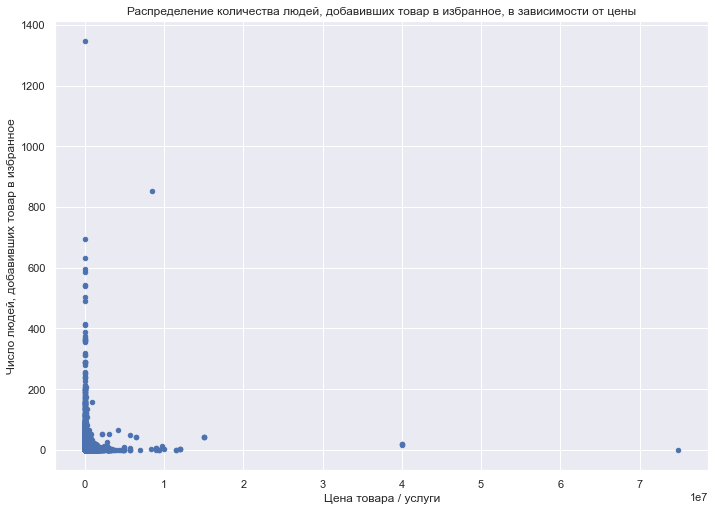

In [244]:
df.plot.scatter(x = "Price", y = "Favourites_count")
plt.title("Распределение количества людей, добавивших товар в избранное, в зависимости от цены")
plt.xlabel("Цена товара / услуги")
plt.ylabel("Число людей, добавивших товар в избранное")
plt.show()

Данная диаграмма рассеяния неудобна для анализа, поэтому исключим строки с данными о бесплатных товарах, а также отфильтруем выбросы (объявления, которые добавили в избранное более 500 раз или цена которых превышает 500000 рублей)

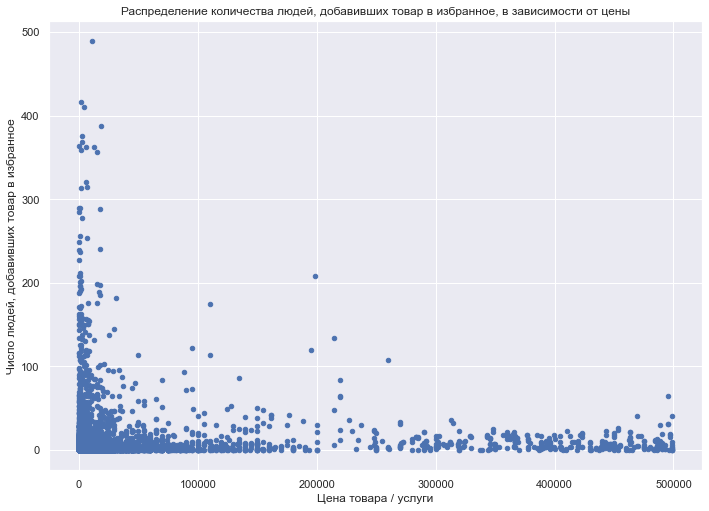

Корреляция между ценой и числом людей, добавивших объявление в избранное: 0.031


In [245]:
filtered = df[(df["Favourites_count"] < 500) & (df["Price"] < 500000)]

filtered.plot.scatter(x = "Price", y = "Favourites_count")
plt.title("Распределение количества людей, добавивших товар в избранное, в зависимости от цены")
plt.xlabel("Цена товара / услуги")
plt.ylabel("Число людей, добавивших товар в избранное")
plt.show()

сorrelation = filtered["Price"].corr(filtered["Favourites_count"])
print(f'Корреляция между ценой и числом людей, добавивших объявление в избранное: {сorrelation:.3f}')

<i>Гипотеза не подтвердилась</i> - корреляция отсутсвует. Значит цена не является определяющим фактором при выборе товара покупателями, но можно заметить, что покупатели проявляют большую заинтересованность к бесплатным товарам (это отражает скопление точек около 0 на графике).

<h4>H6. Чем больше фотографий представлено в объявлении, тем больше процент людей, добавивших товар в избранное, из числа просмотревших</h4>
Анализ будем производить по столбцам "Images" и "Favourites_percent"; Сначала построим столчатую диаграмму для всего датасета, а затем построим столбчатые диаграммы отдельно для каждой категории товаров и выявим закономерности при их наличии.

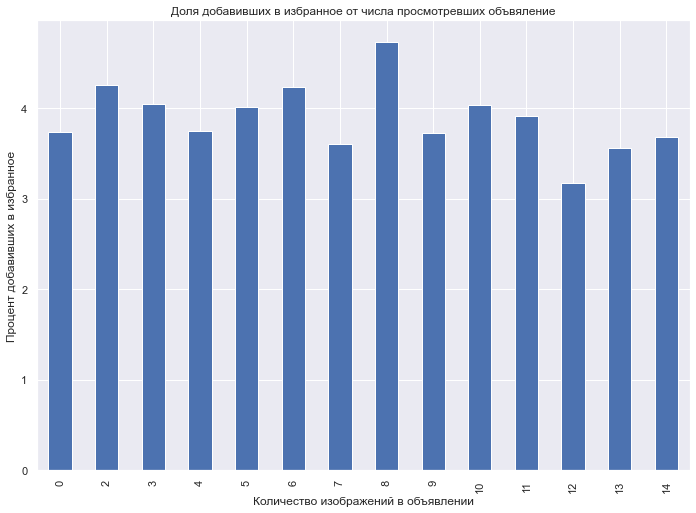

In [246]:
df.groupby("Images")["Favourites_percent"].mean().plot(kind = "bar")
plt.title("Доля добавивших в избранное от числа просмотревших объвяление")
plt.xlabel("Количество изображений в объявлении")
plt.ylabel("Процент добавивших в избранное")
plt.show()

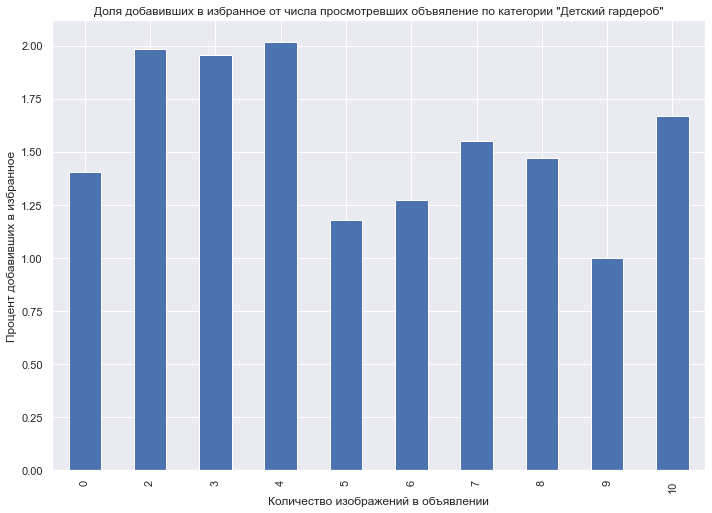

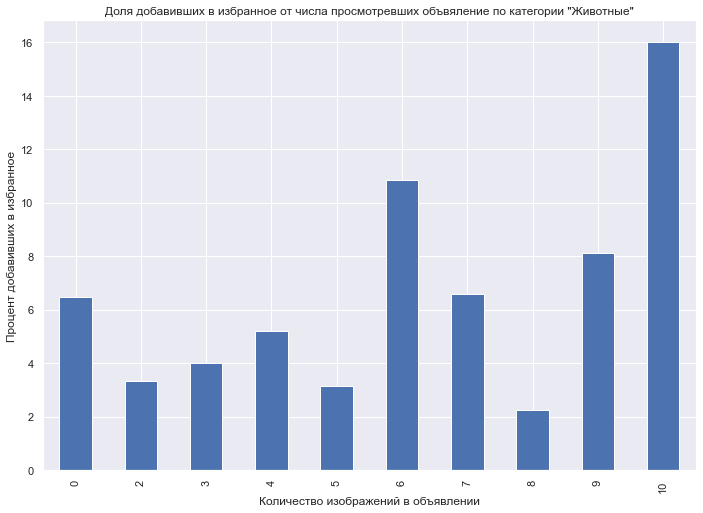

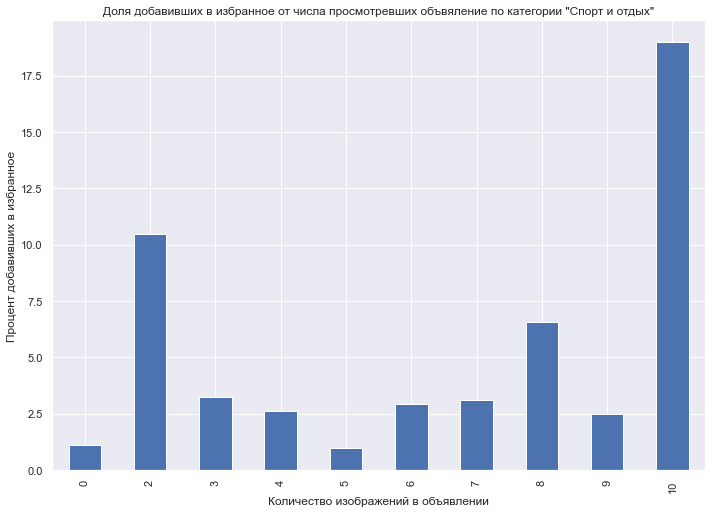

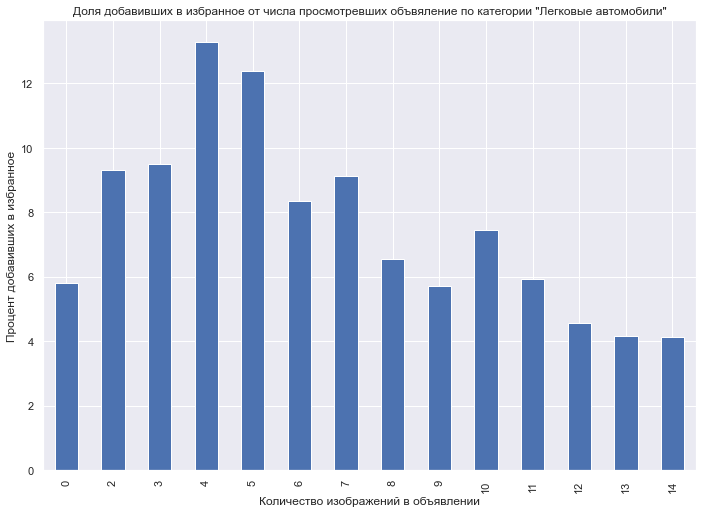

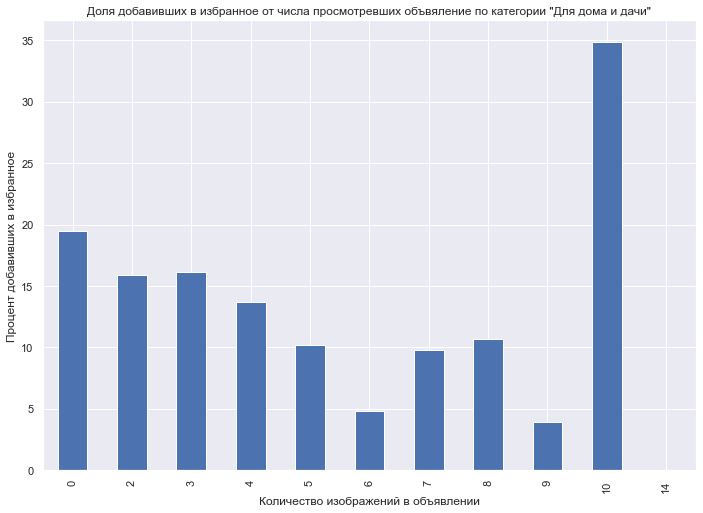

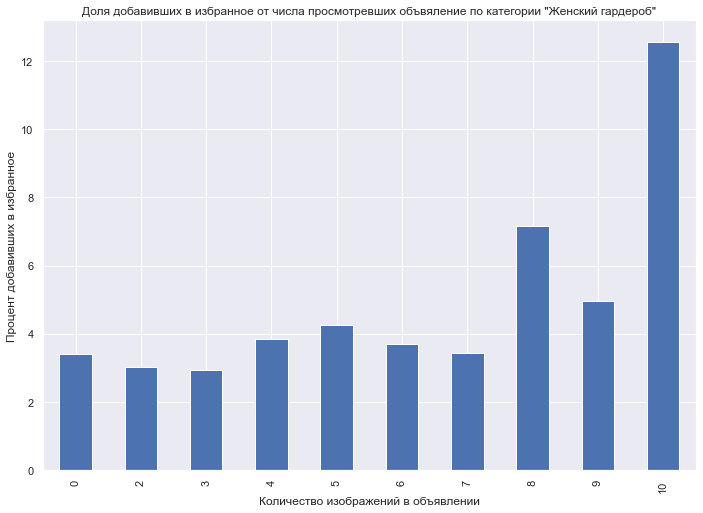

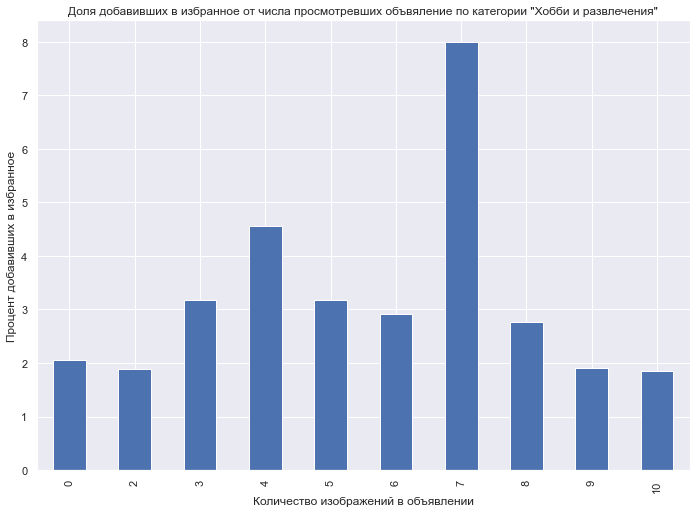

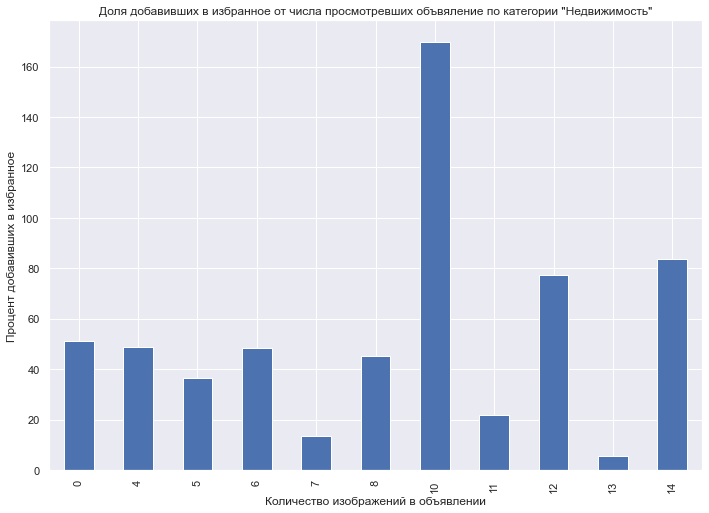

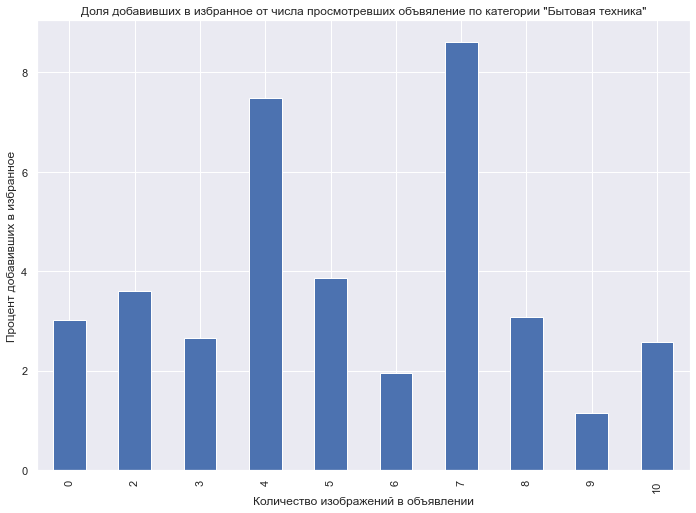

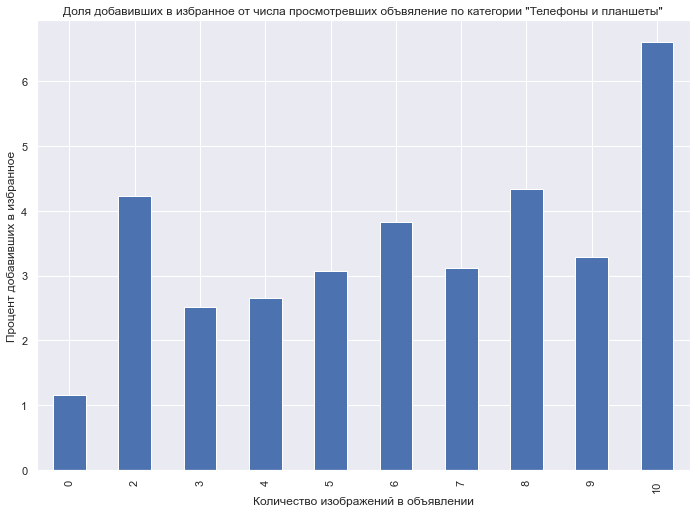

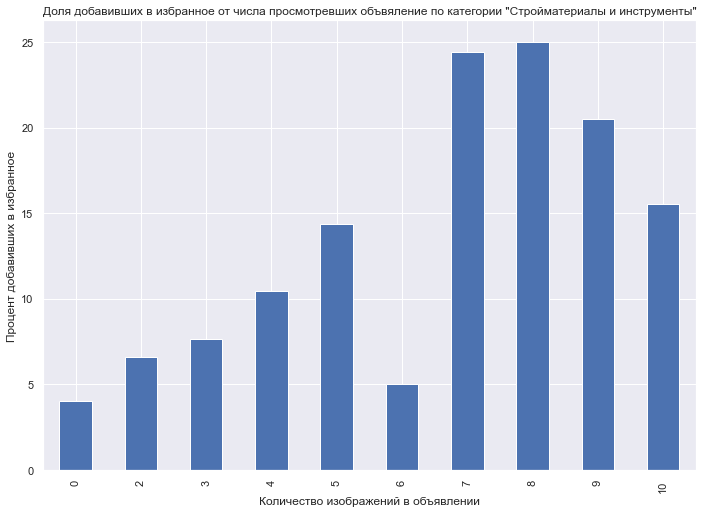

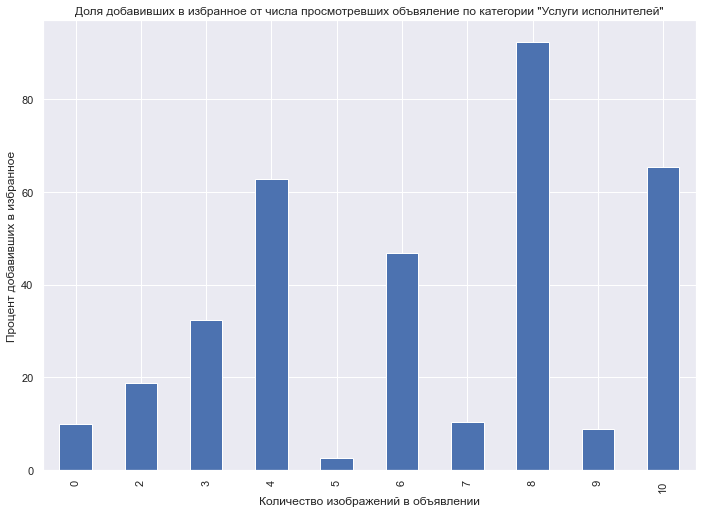

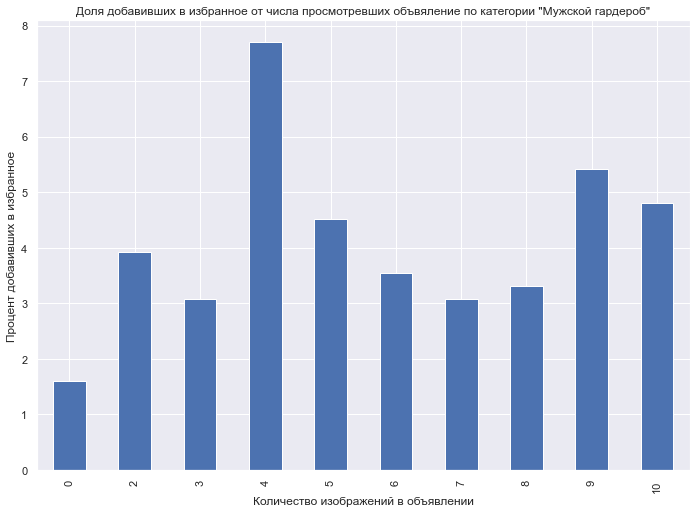

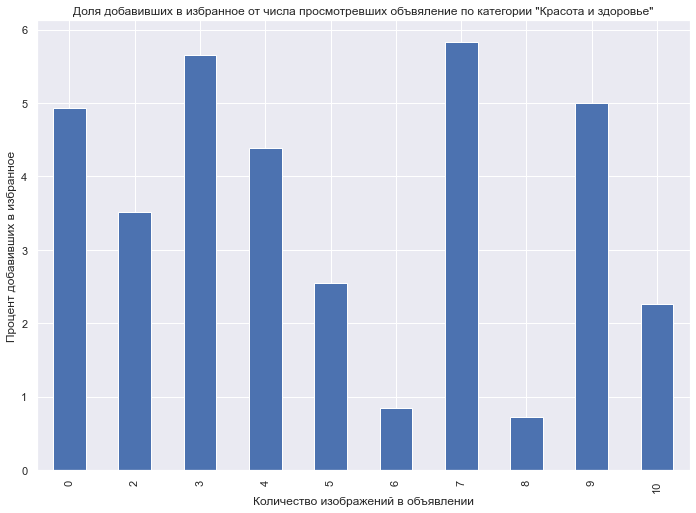

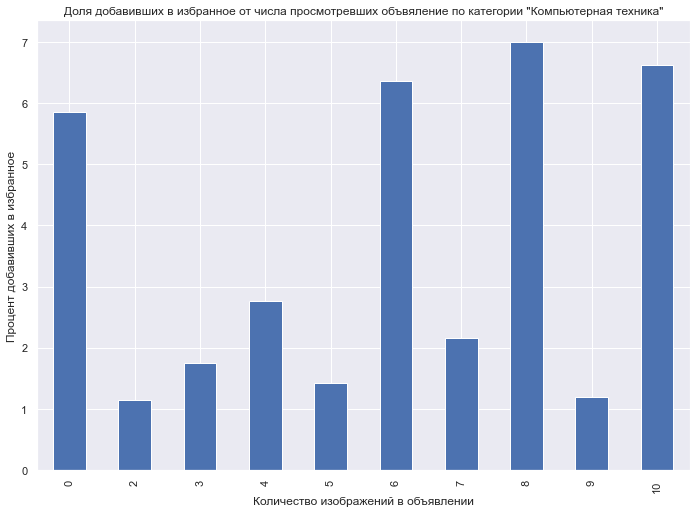

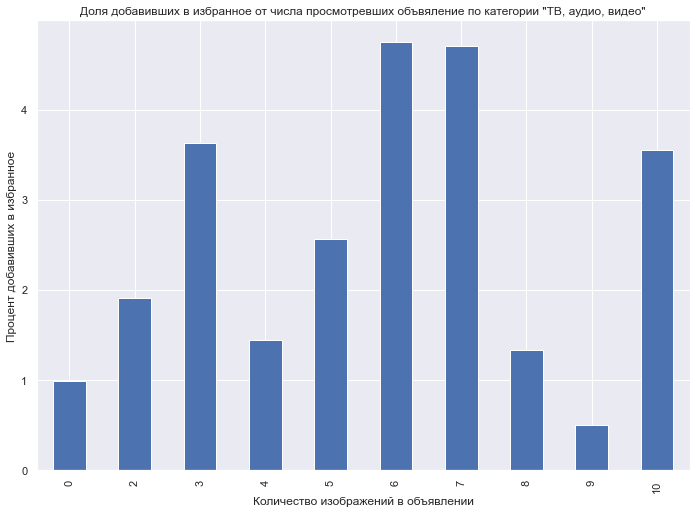

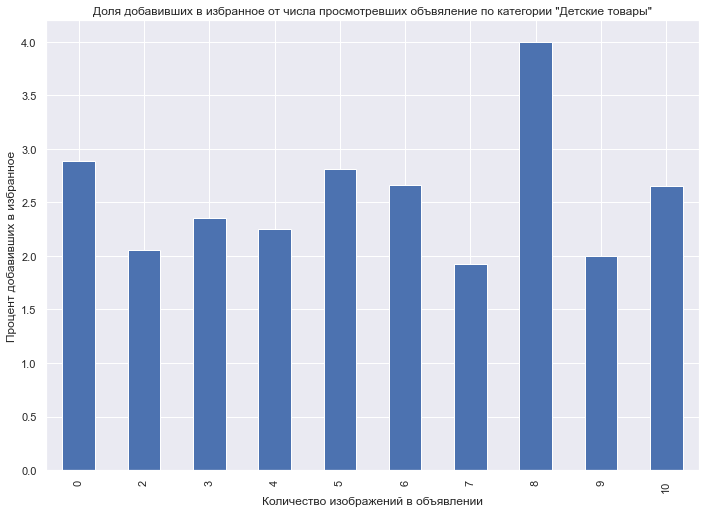

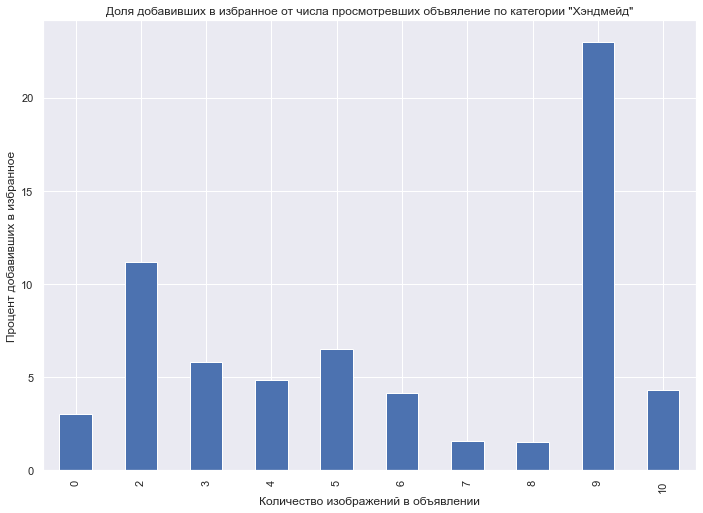

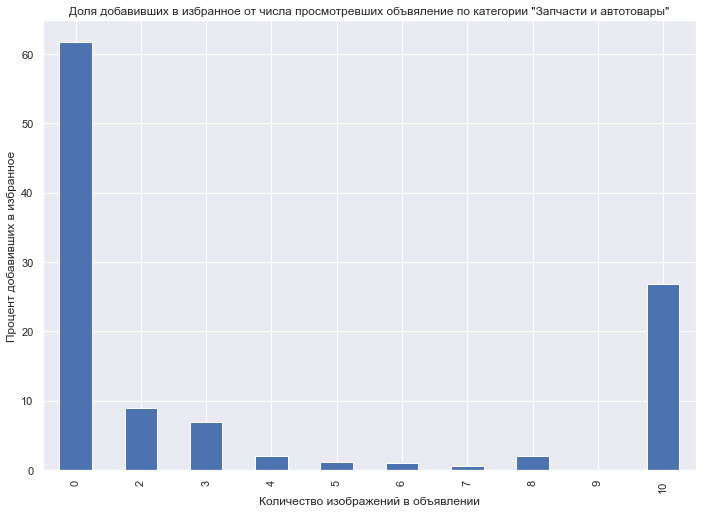

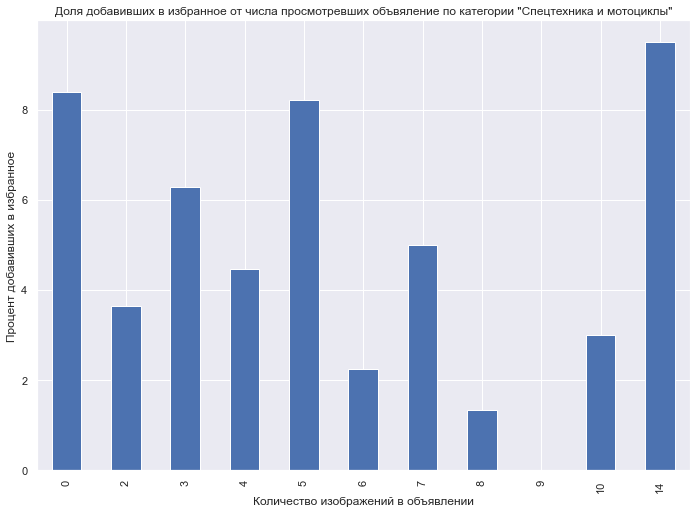

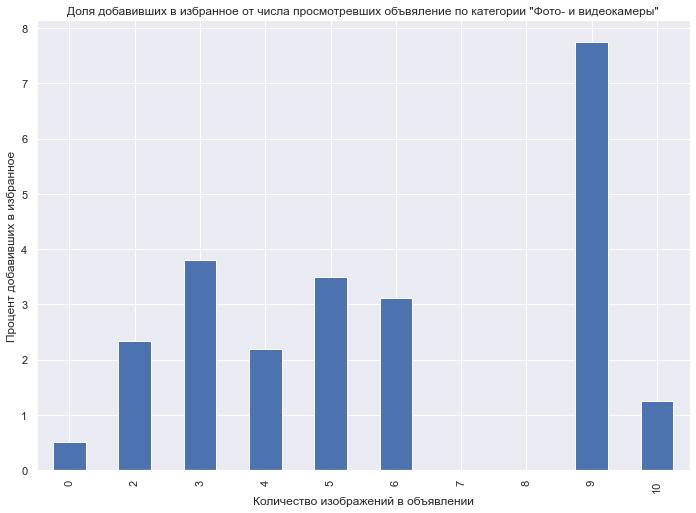

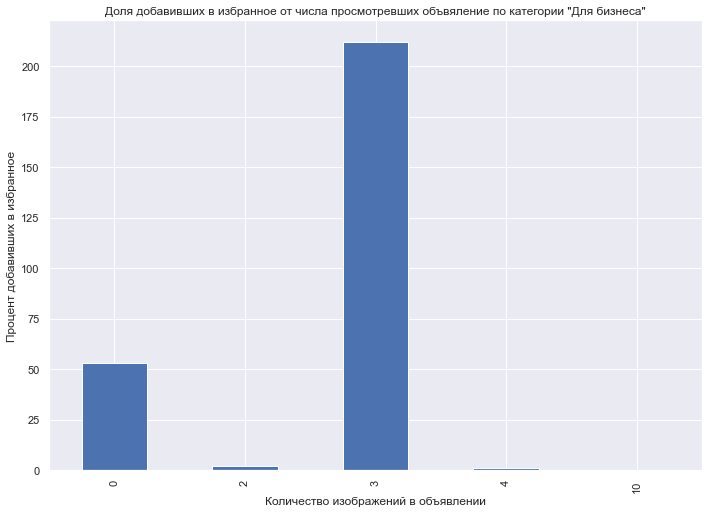

In [247]:
for cat in df["Category"].unique():
    if(cat == "Вакансии"):
        continue
    df[df["Category"] == cat].groupby("Images")["Favourites_count"].mean().plot(kind = "bar")
    plt.title(f"Доля добавивших в избранное от числа просмотревших объвяление по категории \"{cat}\"")
    plt.xlabel("Количество изображений в объявлении")
    plt.ylabel("Процент добавивших в избранное")
    plt.show()

<i>Гипотеза не подтвердилась</i> - общая зависимость по всем категориям отсутствует.  
<ul>
    <li>Но в некоторых категориях можно наблюдать наличие такой зависимости (например в категории "Телефоны и планшеты"); </li>
    <li>в других категориях можно наблюдать некоторое значение количества фотографий, до достижения которого количество добавивших в избранное увеличивается, а затем начинает падать (например категории "Стройматериалы и инструменты", "Легковые автомобили");</li>
    <li>также есть категории, в которых можно установить общую зависимость, но в них присутсвуют резкие отклонения от общей тенденции для конкретного количества изображений (например в категории "Услуги испольнителей" существует прямая зависимость между исследуемымы переменными, но присуствуют резкие падения для 5, 7 и 9 фотографий; в категории "Хэндмейд" есть небольшая обратная зависимость с разким пиком в 9 фотографиях).</li>
    <li>Отдельно можно отметить категорию "Запчасти и товары", в которой наибольший процент заинтересованности покупатели объявляют к тем объявлениям, где вообще нет фотографий, это говорит о том, что при размещении объявления продавцу очень важно обращать внимание на специфику категории его товара.</li>
</ul>

<h4>H7. Покупатели больше обращают внимания на товары из среднего ценового сегмента</h4>

Логично определять заинтересованность покупателей по проценту добавивших товар в избранное от общего числа покупателей, либо просто по числу добавивших в избранное, нами был выбран второй вариант, поэтому для проверки данной гипотезы рассматриваются следующие столбцы: "Favourites_count", "Price_range", "Category";  
Выбранный метод анализа: построение сводной таблицы - данный метод позволяет выделить зависимости не только по всей группе целиком, но и по отдельным категориям

In [248]:
df.pivot_table('Favourites_count', index='Price_range', columns='Category')

Category,Бытовая техника,Вакансии,Детские товары,Детский гардероб,Для бизнеса,Для дома и дачи,Женский гардероб,Животные,Запчасти и автотовары,Компьютерная техника,...,Недвижимость,Спецтехника и мотоциклы,Спорт и отдых,Стройматериалы и инструменты,"ТВ, аудио, видео",Телефоны и планшеты,Услуги исполнителей,Фото- и видеокамеры,Хобби и развлечения,Хэндмейд
Price_range,,,,,,,,,,,,,,,,,,,,,
affordable,4.699,NaN,5.056,0.429,NaN,23.244,10.830,10.102,3.143,3.081,...,163.333,3.438,8.117,12.779,2.138,3.930,30.750,2.200,3.038,15.438
expensive,3.622,NaN,2.231,0.000,14.000,25.029,7.062,3.943,2.154,2.949,...,58.500,6.621,8.345,4.056,4.381,3.095,1.000,2.091,3.514,7.333
free,3.667,103.000,2.265,1.974,NaN,2.692,4.250,5.129,0.000,0.000,...,NaN,1.167,0.000,1.500,0.000,1.152,NaN,4.000,7.250,0.000
luxury,1.000,NaN,0.000,NaN,18.000,0.333,4.800,1.333,NaN,0.300,...,56.235,4.000,0.000,3.000,0.000,0.000,NaN,2.000,2.000,1.000
small price,3.197,NaN,2.180,1.662,206.000,9.640,3.291,6.162,33.125,3.561,...,88.043,15.235,3.541,9.717,2.373,3.770,34.124,3.350,2.500,4.754


<i>Гипотеза подтвердилась</i> - в большинстве категорий товары из среднего ценового сегмента добавляют в избранное чаще остальных, за исключением нескольких категорий

<h4><b>H8. </b>Средняя цена на товары из категорий "Недвижимость", "Легковые автомобили", "Бытовая техника", "Одежда" в Москве выше средней цены в других регионах</h4>
Рассматриваемые столбцы: "Region", "Category", "Price"<br>
Выбранный метод анализа: построение сводной таблицы для рассмотрения различных регионов


In [249]:
pd.options.display.float_format = '{:.3f}'.format
dfRegion = df.copy(deep=True).dropna(subset=["Region"])
dfRegion["Region"] = dfRegion["Region"].apply(lambda x : "Москва" if "Москва" in x else x)
dfRegion["Category"] = dfRegion["Category"].apply(lambda x : "Одежда" if x in set(["Детский гардероб", "Мужской гардероб", "Женский гардероб"]) else x)

regions = []
for i in dfRegion["Region"].unique():
    if(dfRegion.Region.value_counts()[i] > 15):
        regions.append(i)


flags = [',' not in i for i in dfRegion["Region"]]
dfRegion = dfRegion[flags]

dfRegion = dfRegion[dfRegion["Category"].isin(["Недвижимость", "Легковые автомобили", "Бытовая техника", "Одежда"])]
dfRegion = dfRegion[dfRegion["Region"].isin(regions)]

dfRegion.pivot_table('Price', index='Region', columns='Category')


Category,Бытовая техника,Легковые автомобили,Недвижимость,Одежда
Region,,,,
Балашиха,8750.000,601428.571,3759500.000,625.000
Видное,14000.000,1019250.000,NaN,2550.000
Волжск,NaN,NaN,NaN,3000.000
Домодедово,NaN,484750.000,NaN,465.000
Зеленоград,NaN,604545.455,NaN,0.000
Красногорск,NaN,664000.000,NaN,2000.000
Лобня,NaN,410000.000,NaN,NaN
Люберцы,8500.000,540800.000,NaN,1875.000
Москва,8585.828,768827.513,3797777.450,4264.422


<i>Нельзя сделать однозначный вывод по данной гипотезе</i>, потому что хорошая выборка значений представлена только по категориям "Легковые автомобили" и "Одежда", а в категориях "Бытовая техника" и "Недвижимость" не хватает данных.  
В категории "Легковые автомобили" Москва стоит наравне с несколькими другими регионами по средней цене товара;  
В категории "Одежда" Москва занимает одну из лидирующих позиций по средней цене товара, но её в этой категории превосходит город Троицк.


<h4>H9. В конце рабочей активность продавцов на сайте выше</h4>

Активность продавцов на сайте будем определять по количеству объявлений, размещенных в конкретный день.<br>
Рассматриваемые столбцы: "Category", "Weekday"<br>
Методы анализа: нахождение моды (по столбцу Weekday для каждой категории), составление сводной таблицы

In [250]:
for cat in df["Category"].unique():
    dfCat = df[df["Category"] == cat]['Weekday']
    print(f'Мода по дню недели в категории \"{cat}\": {dfCat.mode().iat[0]}')
    
df.groupby(['Category', 'Weekday']).size().unstack()

Мода по дню недели в категории "Детский гардероб": Четверг
Мода по дню недели в категории "Животные": Четверг
Мода по дню недели в категории "Спорт и отдых": Среда
Мода по дню недели в категории "Легковые автомобили": Пятница
Мода по дню недели в категории "Для дома и дачи": Четверг
Мода по дню недели в категории "Женский гардероб": Четверг
Мода по дню недели в категории "Хобби и развлечения": Четверг
Мода по дню недели в категории "Недвижимость": Четверг
Мода по дню недели в категории "Бытовая техника": Четверг
Мода по дню недели в категории "Телефоны и планшеты": Четверг
Мода по дню недели в категории "Стройматериалы и инструменты": Четверг
Мода по дню недели в категории "Услуги исполнителей": Пятница
Мода по дню недели в категории "Мужской гардероб": Четверг
Мода по дню недели в категории "Красота и здоровье": Четверг
Мода по дню недели в категории "Компьютерная техника": Четверг
Мода по дню недели в категории "ТВ, аудио, видео": Четверг
Мода по дню недели в категории "Детские товар

Weekday,Воскресенье,Вторник,Понедельник,Пятница,Среда,Суббота,Четверг
Category,,,,,,,
Бытовая техника,39.000,54.000,27.000,57.000,51.000,29.000,79.000
Вакансии,1.000,2.000,NaN,NaN,NaN,NaN,1.000
Детские товары,52.000,92.000,54.000,132.000,56.000,32.000,172.000
Детский гардероб,32.000,63.000,41.000,85.000,43.000,41.000,102.000
Для бизнеса,NaN,1.000,1.000,1.000,NaN,2.000,1.000
Для дома и дачи,104.000,172.000,150.000,231.000,177.000,85.000,304.000
Женский гардероб,117.000,204.000,100.000,234.000,113.000,70.000,261.000
Животные,61.000,110.000,80.000,134.000,128.000,73.000,189.000
Запчасти и автотовары,1.000,13.000,5.000,13.000,10.000,1.000,16.000


<i>Гипотеза подтвердилась</i> - объявления чаще всего размещают в четверг, реже в пятницу;  
Этот факт можно объяснить тем, что продавцы стремятся разместить объявления до выходных, потому что на выходных покупатели проявляют большую активность.

<h4>H10. Заинтересованность покупателей в бесплатных товарах в выбранных категориях выше, чем в платных.</h4>
При проверке данной гипотезы заинтересованность покупателей будем определять по количеству добавивших объявление в избранное, их процентному соотношению, а также по количеству просмотров.<br>
Рассматриваемые столбцы: "Category", "Favourites_percent", "Favourites_count", "Views", "Free_item"<br>
Методы анализа: составление сводных таблиц

Будем проводить анализ по следующим категориям:
<ul>
    <li>Животные</li>
    <li>Для дома и дачи</li>
    <li>Бытовая техника</li>
    <li>Детский гардероб</li>
    <li>Детские товары</li>
</ul>

Сначала определим средний процент людей, добававиших товар в избранное:

In [251]:
dfCat = df.copy(deep=True)
dfCat = dfCat[dfCat["Category"].isin(
    ["Животные", "Для дома и дачи", "Бытовая техника", "Детский гардероб", "Детские товары"])]
print("Средний процент людей, добавивших товар в избранное, по категориям")
dfCat.pivot_table("Favourites_percent", columns="Category", index="Free_item")


Средний процент людей, добавивших товар в избранное, по категориям


Category,Бытовая техника,Детские товары,Детский гардероб,Для дома и дачи,Животные
Free_item,,,,,
False,4.337,4.733,3.167,4.926,3.787
True,3.828,3.030,2.589,3.067,3.696


Теперь определим посмтрим на абсолютное значение - среднее количество людей, добавивших товар в избранное

In [252]:
print("Среднее количество людей, добавивших товар в избранное")
dfCat.pivot_table("Favourites_count", columns="Category", index="Free_item")

Среднее количество людей, добавивших товар в избранное


Category,Бытовая техника,Детские товары,Детский гардероб,Для дома и дачи,Животные
Free_item,,,,,
False,3.928,2.547,1.634,16.445,6.510
True,3.667,2.265,1.974,2.692,5.129


И, наконец, определим среднее количество просмотров

In [253]:
print("Среднее количество просмотров объявления")
dfCat.pivot_table("Views", columns="Category", index="Free_item")

Среднее количество просмотров объявления


Category,Бытовая техника,Детские товары,Детский гардероб,Для дома и дачи,Животные
Free_item,,,,,
False,126.262,82.689,67.907,505.796,263.458
True,114.000,80.600,81.600,56.231,237.963


<i>Гипотеза не подтвердилась</i> - люди проявляют больший интерес к платным товарам (это видно по всем трём сводным таблицам), что кажется контринтуитивным, но может объясняться тем, что уровень жизни людей позволяет покупать более дорогие товары, а также тем, что люди считают платные товары более качественными;  
Исключением являются лишь бесплатные товары детского гардероба, интерес к которым у покупателей не ниже, чем к платным.

<h2>Вывод</h2>

<p>В ходе исследовательской работы мы выполнили поставленные задачи и проанализировали изложенные выше гипотезы, что помогло выявить факторы, влияющие на заинтересованность покупателей в товарах выбранных категорий, а также перспективы продавцов при реализации товаров в этих категориях.</p>
<p>Можно утверждать, что в категориях "Легковые автомобили", "Для дома и дачи" и "Телефоны и планшеты" новым продавцам будет сложно найти покупателя в связи с высокой конкуренцией в данных категориях.</p>
<p>Также можно сделать вывод, что не всегда стоит уменьшать цену товара с целью привлечения покупателей, т.к. нет ярковыраженной зависимости между ценой и заинтересованностью покупателей. Но при этом стоит заметить, что товары попадающие в ценовую категорию менее 5000 рублей пользуются наибольшим спросом </p>
<p>Анализ датасета показывает, что многие продавцы придерживаются стратегии выкладывать объявления ближе к концу рабочей недели, так как активность покупателей на выходных вероятно будет выше, чем в будние дни, поэтому новым продавцам имеет смысл придерживаться подобной тактики.</p>
<p>Так как Юла является онлайн-маркетплейсом, то не стоит делать регион продажи основанием для выбора цены, так как при анализе было выявлено, что даже в некоторых провинциальных городах товары выбранных категорий продаются по более высокой цене, чем в столице.</p>
<p>При публикации объявления на сайте стоит учитывать специфику категории товара и согласно этому уделять больше внимания количеству фотографий в объявлении</p>
<p>Основными факторами, влияющими на заинтересованность покупателей, в зависимости от категории могут быть следующие:
<ul>
    <li>Наличие в городе крупного конкурента. Например в городе Химки может быть тяжело продать автомобиль, так как в нём есть крупный диллер автомобилей.</li>
    <li>День недели, в который публикуется объявление. Данный фактор влияет на товары из многих категорий.</li>
    <li>Наличие альтернативного сервиса размещения объявлений, специализирующегося на выбранной категории. Например, в ходе анализа было показано, что услуги на Юле представлены не очень широко, т.к. существуют площадки, основным направлением которых является поиск и предоставление услуг, аналогичная ситуация наблюдается в категории недвижимости, где есть много разных альтернатив, например Циан.</li>
</ul>
</p>

<br>
<br>
<p>
    Некоторые выводы исследования оказались неожиданными, например при проверке гипотезы H3 выяснилось, что существует много
    регионов, в которых товары роскоши составляют больший процент от всех товаров, чем в Москве, причем зачастую это различие
    может быть кратным, например в Зеленограде процент роскоши в 2-3 раза происходит таковой в столице.<br>
    В то же время некоторые выводы исследования вполне ожидаемы, например, активность продавцов в конце недели (H9) кажется
    довольно логичной и предсказуемой
</p>
